In [9]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import tensorflow as tf
from keras import layers, models
import numpy as np
import datetime
#import capsnet
from SegCaps import capsule_layers
import dataset
import model_functions as mf
import audio_functions as af

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'


In [11]:
#  Set other variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=2
normalise=True
batch_size = 1
shuffle=False
n_shuffle = 10
mag_phase = True

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/minimini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/minimini/Voice/train-clean-100/19/198/'

#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise,
                                  mag_phase)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, mixed_audio, voice_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

In [12]:
class SegCaps_CapsNetBasic(object):
    
    def __init__(self, mixed_mag, mixed_phase, voice_mag, is_training, reuse=True, name='SegCaps_CapsNetBasic'):
        """
        input_tensor: Tensor with shape [batch_size, height, width, channels]
        is_training:  Boolean - should the model be trained on the current input or not
        name:         Model instance name
        """
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag
            self.mixed_phase = mixed_phase
            self.voice_mag = voice_mag
            
            with tf.variable_scope('Convolution'):
                conv1 = mf.conv(mixed_mag, filters=128, kernel_size=5, stride=(1, 1))
                
                # Reshape layer to be 1 capsule x [filters] atoms
                _, H, W, C = conv1.get_shape()
                conv1 = layers.Reshape((H.value, W.value, 1, C.value))(conv1)
                #conv1 = tf.expand_dims(conv1, 2)
                self.conv1 = conv1
            
            with tf.variable_scope('Primary_Caps'):
                primary_caps = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=16, strides=1, padding='same',
                                                               routings=1, name='primarycaps')(conv1)
                self.primary_caps = primary_caps
                
            with tf.variable_scope('Seg_Caps'):
                seg_caps = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
                                                           routings=3, name='seg_caps')(primary_caps)
                self.seg_caps = seg_caps
            
            with tf.variable_scope('Reconstruction'):
                reconstruction = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=1, strides=1, padding='same',
                                                           routings=3, name='seg_caps')(seg_caps)
                reconstruction = tf.squeeze(reconstruction,-1)
                self.reconstruction = reconstruction
            
            self.cost = mf.l1_loss(self.reconstruction, voice_mag)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0002,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.cost)

In [13]:
class UNetModel(object):
    """
    Top level U-Net object.
    Attributes:
        mixed_mag: Input placeholder for magnitude spectrogram of mixed signals (voice plus background noise) - X
        voice_mag: Input placeholder for magnitude spectrogram of isolated voice signal - Y
        mixed_phase: Input placeholder for phase spectrogram of mixed signals (voice plus background noise)
        mixed_audio: Input placeholder for waveform audio of mixed signals (voice plus background noise)
        voice_audio: Input placeholder for waveform audio of isolated voice signal
        variant: The type of U-Net model (Normal convolutional or capsule based)
        is_training: Boolean - should the model be trained on the current input or not
        name: Model instance name
    """
    def __init__(self, mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, variant, is_training, name):
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag
            self.voice_mag = voice_mag
            self.mixed_phase = mixed_phase
            self.mixed_audio = mixed_audio
            self.voice_audio = voice_audio
            self.variant = variant
            self.is_training = is_training

            self.voice_mask_unet = UNet(mixed_mag, variant, is_training=is_training, reuse=False, name='voice-mask-unet')

            self.voice_mask = self.voice_mask_unet.output

            self.gen_voice = self.voice_mask * mixed_mag

            self.pw_cost = mf.pw_l1_loss(self.gen_voice, voice_mag)
            self.cost = tf.reduce_mean(self.pw_cost)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0002,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.pw_cost)


class UNet(object):

    def __init__(self, input_tensor, variant, is_training, reuse, name):
        with tf.variable_scope(name, reuse=reuse):
            self.variant = variant

            if self.variant == 'unet':
                self.encoder = UNetEncoder(input_tensor, is_training, reuse)
                self.decoder = UNetDecoder(self.encoder.output, self.encoder, is_training, reuse)
            elif self.variant == 'capsunet':
                self.encoder = CapsUNetEncoder(input_tensor, is_training, reuse)
                self.decoder = CapsUNetDecoder(self.encoder.output, self.encoder, is_training, reuse)

            self.output = mf.tanh(self.decoder.output) / 2 + .5

class UNetEncoder(object):
    """
    The down-convolution side of a convoltional U-Net model.
    """

    def __init__(self, input_tensor, is_training, reuse):
        net = input_tensor
        with tf.variable_scope('encoder'):
            with tf.variable_scope('layer-1'):
                net = mf.conv(net, filters=16, kernel_size=5, stride=(2, 2))
                self.l1 = net

            with tf.variable_scope('layer-2'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=32, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l2 = net

            with tf.variable_scope('layer-3'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=64, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l3 = net

            with tf.variable_scope('layer-4'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=128, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l4 = net

            with tf.variable_scope('layer-5'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=256, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                self.l5 = net

            with tf.variable_scope('layer-6'):
                net = mf.lrelu(net)
                net = mf.conv(net, filters=512, kernel_size=5, stride=(2, 2))

            self.output = net


class UNetDecoder(object):
    """
    The up-convolution side of a convolutional U-Net model
    """
    def __init__(self, input_tensor, encoder, is_training, reuse):
        net = input_tensor

        with tf.variable_scope('decoder'):
            with tf.variable_scope('layer-1'):
                net = mf.relu(net)
                net = mf.deconv(net, filters=256, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                net = mf.dropout(net, .5)

            with tf.variable_scope('layer-2'):
                net = mf.relu(mf.concat(net, encoder.l5))
                net = mf.deconv(net, filters=128, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                net = mf.dropout(net, .5)

            with tf.variable_scope('layer-3'):
                net = mf.relu(mf.concat(net, encoder.l4))
                net = mf.deconv(net, filters=64, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)
                net = mf.dropout(net, .5)

            with tf.variable_scope('layer-4'):
                net = mf.relu(mf.concat(net, encoder.l3))
                net = mf.deconv(net, filters=32, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)

            with tf.variable_scope('layer-5'):
                net = mf.relu(mf.concat(net, encoder.l2))
                net = mf.deconv(net, filters=16, kernel_size=5, stride=(2, 2))
                net = mf.batch_norm(net, is_training=is_training, reuse=reuse)

            with tf.variable_scope('layer-6'):
                net = mf.relu(mf.concat(net, encoder.l1))
                net = mf.deconv(net, filters=1, kernel_size=5, stride=(2, 2))

            self.output = net

            
class CapsUNetEncoder(object):
    """
    The down-convolutional side of a capsule based U-Net model (based on SegCaps R3 model).
    """
    def __init__(self, input_tensor, is_training, reuse):
        #net = layers.Input(shape=input_tensor)
        net = input_tensor
        with tf.variable_scope('Encoder'):
            with tf.variable_scope('Convolution'):
                # Layer 1: A conventional Conv2D layer
                net = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', name='conv1')(net)
                self.conv1 = net
                
                # Reshape layer to be 1 capsule x [filters] atoms
                _, H, W, C = net.get_shape()
                net = layers.Reshape((H.value, W.value, 1, C.value))(net)
                

            # Layer 1: Primary Capsule: Conv cap with routing 1
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=2, num_atoms=8, strides=2, padding='same',
                                                routings=1, name='primarycaps')(net)
            self.primary_caps = net

            # Layer 2: Convolutional Capsules
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=8, strides=2, padding='same',
                                                  routings=3, name='conv_cap_2')(net)
            self.conv_cap_2 = net

            # Layer 3: Convolutional Capsules
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=16, strides=2, padding='same',
                                                  routings=3, name='conv_cap_3')(net)
            self.conv_cap_3 = net

            # Layer 4: Convolutional Capsules
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=2, padding='same',
                                                  routings=3, name='conv_cap_4')(net)

            self.output = net


class CapsUNetDecoder(object):
    """
    The up-convolutional side of a capsule based U-Net model.
    """
    def __init__(self, input_tensor, encoder, is_training, reuse):
        net = input_tensor
        with tf.variable_scope('Decoder'):
                # Layer 1 Up: Deconvolutional capsules, skip connection, convolutional capsules
            net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=8, num_atoms=16, upsamp_type='deconv',
                                                    scaling=2, padding='same', routings=3, name='deconv_cap_1')(net)
            self.upcap_1 = net

            net = layers.Concatenate(axis=-2, name='skip_1')([net, encoder.conv_cap_3])

            # Layer 2 Up: Deconvolutional capsules, skip connection, convolutional capsules
            net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=4, num_atoms=8, upsamp_type='deconv',
                                                    scaling=2, padding='same', routings=3, name='deconv_cap_2')(net)
            self.upcap_2 = net

            net = layers.Concatenate(axis=-2, name='skip_2')([net, encoder.conv_cap_2])

            # Layer 3 Up: Deconvolutional capsules, skip connection
            net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=2, num_atoms=8, upsamp_type='deconv',
                                                    scaling=2, padding='same', routings=3, name='deconv_cap_3')(net)
            self.upcap_3 = net

            net = layers.Concatenate(axis=-2, name='skip_3')([net, encoder.primary_caps])
            
            # Layer 4: Reconstruction - Convolutional Capsule: 1x1, 3x conventional Conv2D layers
            #net = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
            #                                      routings=3, name='seg_caps')(net)
            net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=1, num_atoms=16, upsamp_type='deconv',
                                                    scaling=2, padding='same', routings=3, name='deconv_cap_4')(net)
            self.upcap_4 = net

            _, H, W, C, D = net.get_shape()

            net = layers.Reshape((H.value, W.value, D.value))(net)
            net = layers.Concatenate(axis=-1, name='skip_4')([net, encoder.conv1])

            net = layers.Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                activation='relu', name='recon_1')(net)

            net = layers.Conv2D(filters=128, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                activation='relu', name='recon_2')(net)

            net = layers.Conv2D(filters=1, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                activation='sigmoid', name='out_recon')(net)

            self.output = net

In [14]:
#tf.reset_default_graph()
#model = SegCaps_CapsNetBasic(mixed_mag, mixed_phase, voice_mag, is_training=False)
model = UNetModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, 'capsunet', is_training=True, name='R3_CapsNet')
#model = UNetModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, 'unet', is_training=True, name='R3_CapsNet')

### Basic Caps Net - Layer Dimensions

In [53]:
print('Layers\' Shapes:\n'
      '\nInput: ', mixed_mag.get_shape().as_list(),
      '\nConvolution: ',model.conv1.get_shape().as_list(),
      '\nPrimary Caps: ',model.primary_caps.get_shape().as_list(),
      '\nSeg Caps: ',model.seg_caps.get_shape().as_list(),
      '\nRecontruction: ',model.reconstruction.get_shape().as_list())

Layers' Shapes:

Input:  [None, 256, 512, 1] 
Convolution:  [None, 256, 512, 1, 128] 
Primary Caps:  [None, 256, 512, 8, 16] 
Seg Caps:  [None, 256, 512, 1, 16] 
Recontruction:  [None, 256, 512, 1]


### R3 Caps Net - Layer Dimensions

In [15]:
print('Layers\' Shapes:\n'
      '\nInput: ', mixed_mag.get_shape().as_list(),
      '\nConvolution: ',model.voice_mask_unet.encoder.conv1.get_shape().as_list(),
      '\nPrimary Caps: ',model.voice_mask_unet.encoder.primary_caps.get_shape().as_list(),
      '\nConv Caps 2: ',model.voice_mask_unet.encoder.conv_cap_2.get_shape().as_list(),
      '\nConv Caps 3: ',model.voice_mask_unet.encoder.conv_cap_3.get_shape().as_list(),
      '\nConv Caps 4 (output): ',model.voice_mask_unet.encoder.output.get_shape().as_list(),
      
      '\n\nUp Caps 1: ',model.voice_mask_unet.decoder.upcap_1.get_shape().as_list(),
      '\nUp Caps 2: ',model.voice_mask_unet.decoder.upcap_2.get_shape().as_list(),
      '\nUp Caps 3: ',model.voice_mask_unet.decoder.upcap_3.get_shape().as_list(),
      '\nUp Caps 4: ',model.voice_mask_unet.decoder.upcap_4.get_shape().as_list(),
      '\nReconstruction (output): ',model.voice_mask_unet.decoder.output.get_shape().as_list()
      )

Layers' Shapes:

Input:  [None, 256, 512, 1] 
Convolution:  [None, 256, 512, 16] 
Primary Caps:  [None, 128, 256, 2, 8] 
Conv Caps 2:  [None, 64, 128, 4, 8] 
Conv Caps 3:  [None, 32, 64, 8, 16] 
Conv Caps 4 (output):  [None, 16, 32, 8, 32] 

Up Caps 1:  [None, 32, 64, 8, 16] 
Up Caps 2:  [None, 64, 128, 4, 8] 
Up Caps 3:  [None, 128, 256, 2, 8] 
Up Caps 4:  [None, 256, 512, 1, 16] 
Reconstruction (output):  [None, 256, 512, 1]


In [17]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())
sess.run(pipe.initializer)

In [78]:
mix, phase, voice, mask = sess.run([model.mixed_mag, model.mixed_phase, model.voice_mag, model.voice_mask])

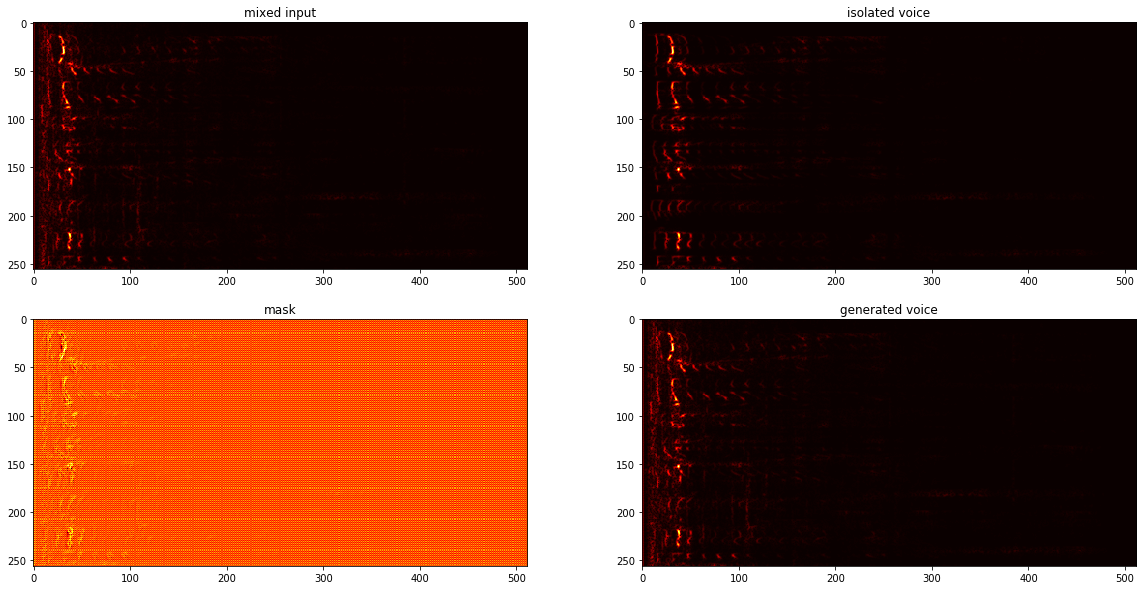

In [79]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix[0,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice[0,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(mix[0,:,:,0] * mask[0,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

In [30]:
print('start: {}'.format(datetime.datetime.now()))
epochs = 2000
epoch = 0
epoch_cost = []
i = 0
while epoch < epochs:
    try:
        _, mix, phase, voice, mask, cost = sess.run([model.train_op, model.mixed_mag, model.mixed_phase, 
                                                     model.voice_mag, model.voice_mask, model.cost])

        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.datetime.now()))

    

start: 2018-10-23 17:40:27.517385
Epoch 0 finished. Mean cost = 0.0035375738050788643
Epoch 1 finished. Mean cost = 0.0035348743898794056
Epoch 2 finished. Mean cost = 0.0035302921819190185
Epoch 3 finished. Mean cost = 0.0035285627702251075
Epoch 4 finished. Mean cost = 0.0035268730483949185
Epoch 5 finished. Mean cost = 0.0035256694924707213
Epoch 6 finished. Mean cost = 0.0035253944008478096
Epoch 7 finished. Mean cost = 0.0035246855404693633
Epoch 8 finished. Mean cost = 0.0035260904166433548
Epoch 9 finished. Mean cost = 0.0035254871705546974
Epoch 10 finished. Mean cost = 0.003524769812991673
Epoch 11 finished. Mean cost = 0.00352433486841619
Epoch 12 finished. Mean cost = 0.0035241379044376885
Epoch 13 finished. Mean cost = 0.0035244180321959513
Epoch 14 finished. Mean cost = 0.00352525284824272
Epoch 15 finished. Mean cost = 0.0035250360873760656
Epoch 16 finished. Mean cost = 0.003524642133647028
Epoch 17 finished. Mean cost = 0.003524347024762796
Epoch 18 finished. Mean cost 

Epoch 155 finished. Mean cost = 0.003497538211433074
Epoch 156 finished. Mean cost = 0.0034973990732720893
Epoch 157 finished. Mean cost = 0.0034972379010618677
Epoch 158 finished. Mean cost = 0.0034970658916230286
Epoch 159 finished. Mean cost = 0.0034968976877280513
Epoch 160 finished. Mean cost = 0.0034967395951335106
Epoch 161 finished. Mean cost = 0.003496564384032455
Epoch 162 finished. Mean cost = 0.0034963948289332396
Epoch 163 finished. Mean cost = 0.0034962226230673857
Epoch 164 finished. Mean cost = 0.003496076771425027
Epoch 165 finished. Mean cost = 0.0034959199131432785
Epoch 166 finished. Mean cost = 0.003495754682999885
Epoch 167 finished. Mean cost = 0.0034955973656559808
Epoch 168 finished. Mean cost = 0.0034954337871594895
Epoch 169 finished. Mean cost = 0.0034952800627797843
Epoch 170 finished. Mean cost = 0.0034951453786125483
Epoch 171 finished. Mean cost = 0.0034950321773067118
Epoch 172 finished. Mean cost = 0.0034948788386785744
Epoch 173 finished. Mean cost = 

Epoch 308 finished. Mean cost = 0.00347723161204926
Epoch 309 finished. Mean cost = 0.0034771117327674745
Epoch 310 finished. Mean cost = 0.003476991052095482
Epoch 311 finished. Mean cost = 0.0034768907357759487
Epoch 312 finished. Mean cost = 0.0034767785195868235
Epoch 313 finished. Mean cost = 0.0034766572376321646
Epoch 314 finished. Mean cost = 0.0034765695178851723
Epoch 315 finished. Mean cost = 0.00347646889085233
Epoch 316 finished. Mean cost = 0.0034763548515842823
Epoch 317 finished. Mean cost = 0.003476249621068157
Epoch 318 finished. Mean cost = 0.003476156459151998
Epoch 319 finished. Mean cost = 0.003476039129745914
Epoch 320 finished. Mean cost = 0.003475924879399555
Epoch 321 finished. Mean cost = 0.0034757991409600244
Epoch 322 finished. Mean cost = 0.003475689007857405
Epoch 323 finished. Mean cost = 0.0034756049464951142
Epoch 324 finished. Mean cost = 0.0034754801630400693
Epoch 325 finished. Mean cost = 0.0034753560268554404
Epoch 326 finished. Mean cost = 0.0034

Epoch 462 finished. Mean cost = 0.003460642801935646
Epoch 463 finished. Mean cost = 0.0034605493993851645
Epoch 464 finished. Mean cost = 0.0034604451210508425
Epoch 465 finished. Mean cost = 0.0034603408663713498
Epoch 466 finished. Mean cost = 0.0034602353968547868
Epoch 467 finished. Mean cost = 0.00346013482602345
Epoch 468 finished. Mean cost = 0.003460032098900789
Epoch 469 finished. Mean cost = 0.0034599262688982677
Epoch 470 finished. Mean cost = 0.003459825407369596
Epoch 471 finished. Mean cost = 0.0034597245589593206
Epoch 472 finished. Mean cost = 0.0034596224410959517
Epoch 473 finished. Mean cost = 0.0034595293541073422
Epoch 474 finished. Mean cost = 0.003459438206431897
Epoch 475 finished. Mean cost = 0.003459333520707432
Epoch 476 finished. Mean cost = 0.003459230659088311
Epoch 477 finished. Mean cost = 0.0034591257364672283
Epoch 478 finished. Mean cost = 0.00345901849267456
Epoch 479 finished. Mean cost = 0.003458912538480945
Epoch 480 finished. Mean cost = 0.00345

Epoch 615 finished. Mean cost = 0.003446304266849025
Epoch 616 finished. Mean cost = 0.003446217669201245
Epoch 617 finished. Mean cost = 0.003446125621910427
Epoch 618 finished. Mean cost = 0.0034460338230526168
Epoch 619 finished. Mean cost = 0.0034459421197102678
Epoch 620 finished. Mean cost = 0.0034458470979972402
Epoch 621 finished. Mean cost = 0.003445753681853749
Epoch 622 finished. Mean cost = 0.0034456582766109974
Epoch 623 finished. Mean cost = 0.0034455682155497087
Epoch 624 finished. Mean cost = 0.003445481964945793
Epoch 625 finished. Mean cost = 0.003445398509829713
Epoch 626 finished. Mean cost = 0.0034453221856715955
Epoch 627 finished. Mean cost = 0.003445237938679494
Epoch 628 finished. Mean cost = 0.0034451523774994956
Epoch 629 finished. Mean cost = 0.00344506625463033
Epoch 630 finished. Mean cost = 0.0034449735163414345
Epoch 631 finished. Mean cost = 0.0034448875919650484
Epoch 632 finished. Mean cost = 0.003444810421904917
Epoch 633 finished. Mean cost = 0.0034

Epoch 769 finished. Mean cost = 0.0034328232807191938
Epoch 770 finished. Mean cost = 0.00343273976327303
Epoch 771 finished. Mean cost = 0.0034326562283975627
Epoch 772 finished. Mean cost = 0.003432570299601127
Epoch 773 finished. Mean cost = 0.0034324847991417046
Epoch 774 finished. Mean cost = 0.0034324017701850783
Epoch 775 finished. Mean cost = 0.0034323167958964125
Epoch 776 finished. Mean cost = 0.003432230580600513
Epoch 777 finished. Mean cost = 0.0034321488166146534
Epoch 778 finished. Mean cost = 0.0034320695163737097
Epoch 779 finished. Mean cost = 0.0034319835199186437
Epoch 780 finished. Mean cost = 0.003431898617351406
Epoch 781 finished. Mean cost = 0.0034318114698166625
Epoch 782 finished. Mean cost = 0.0034317246077422855
Epoch 783 finished. Mean cost = 0.003431637502722062
Epoch 784 finished. Mean cost = 0.003431553535021035
Epoch 785 finished. Mean cost = 0.0034314736208473228
Epoch 786 finished. Mean cost = 0.003431388077573446
Epoch 787 finished. Mean cost = 0.00

Epoch 922 finished. Mean cost = 0.0034207639587137
Epoch 923 finished. Mean cost = 0.0034206914314314787
Epoch 924 finished. Mean cost = 0.003420616836966695
Epoch 925 finished. Mean cost = 0.00342054082267791
Epoch 926 finished. Mean cost = 0.0034204639565247837
Epoch 927 finished. Mean cost = 0.003420386769846965
Epoch 928 finished. Mean cost = 0.003420309267438892
Epoch 929 finished. Mean cost = 0.0034202339919283987
Epoch 930 finished. Mean cost = 0.0034201613840447974
Epoch 931 finished. Mean cost = 0.0034200881657794184
Epoch 932 finished. Mean cost = 0.003420012265479737
Epoch 933 finished. Mean cost = 0.0034199419724047025
Epoch 934 finished. Mean cost = 0.0034198693629792507
Epoch 935 finished. Mean cost = 0.0034197993794929746
Epoch 936 finished. Mean cost = 0.0034197259438398077
Epoch 937 finished. Mean cost = 0.00341965047764713
Epoch 938 finished. Mean cost = 0.0034195761159617807
Epoch 939 finished. Mean cost = 0.003419499895040025
Epoch 940 finished. Mean cost = 0.003419

Epoch 1074 finished. Mean cost = 0.003410276188233564
Epoch 1075 finished. Mean cost = 0.0034102101179296807
Epoch 1076 finished. Mean cost = 0.003410142502672244
Epoch 1077 finished. Mean cost = 0.0034100781000048225
Epoch 1078 finished. Mean cost = 0.003410010984982256
Epoch 1079 finished. Mean cost = 0.003409943655176364
Epoch 1080 finished. Mean cost = 0.003409876362235388
Epoch 1081 finished. Mean cost = 0.003409808668585119
Epoch 1082 finished. Mean cost = 0.003409741682345297
Epoch 1083 finished. Mean cost = 0.0034096743414913926
Epoch 1084 finished. Mean cost = 0.003409609850109791
Epoch 1085 finished. Mean cost = 0.0034095439002943496
Epoch 1086 finished. Mean cost = 0.0034094783836048654
Epoch 1087 finished. Mean cost = 0.0034094131152789275
Epoch 1088 finished. Mean cost = 0.003409351706521926
Epoch 1089 finished. Mean cost = 0.0034092846933598503
Epoch 1090 finished. Mean cost = 0.0034092170751024477
Epoch 1091 finished. Mean cost = 0.003409149622520766
Epoch 1092 finished.

Epoch 1225 finished. Mean cost = 0.0034008366193282033
Epoch 1226 finished. Mean cost = 0.0034007747237477224
Epoch 1227 finished. Mean cost = 0.0034007153099521095
Epoch 1228 finished. Mean cost = 0.0034006582139979855
Epoch 1229 finished. Mean cost = 0.00340059764505311
Epoch 1230 finished. Mean cost = 0.003400537860144768
Epoch 1231 finished. Mean cost = 0.0034004788642050697
Epoch 1232 finished. Mean cost = 0.003400419740231416
Epoch 1233 finished. Mean cost = 0.0034003591254003333
Epoch 1234 finished. Mean cost = 0.0034003000163099904
Epoch 1235 finished. Mean cost = 0.0034002393104352996
Epoch 1236 finished. Mean cost = 0.0034001774063127576
Epoch 1237 finished. Mean cost = 0.0034001177279143224
Epoch 1238 finished. Mean cost = 0.0034000578597623964
Epoch 1239 finished. Mean cost = 0.0033999985184205036
Epoch 1240 finished. Mean cost = 0.003399939928766667
Epoch 1241 finished. Mean cost = 0.003399879694953801
Epoch 1242 finished. Mean cost = 0.003399825651702124
Epoch 1243 finish

Epoch 1376 finished. Mean cost = 0.003392430704821526
Epoch 1377 finished. Mean cost = 0.0033923762409132736
Epoch 1378 finished. Mean cost = 0.003392323029772571
Epoch 1379 finished. Mean cost = 0.003392270428492971
Epoch 1380 finished. Mean cost = 0.0033922203114778236
Epoch 1381 finished. Mean cost = 0.0033921720507229893
Epoch 1382 finished. Mean cost = 0.003392121725966878
Epoch 1383 finished. Mean cost = 0.0033920681643410115
Epoch 1384 finished. Mean cost = 0.0033920146875917267
Epoch 1385 finished. Mean cost = 0.0033919626380240313
Epoch 1386 finished. Mean cost = 0.0033919126736758937
Epoch 1387 finished. Mean cost = 0.0033918592315610036
Epoch 1388 finished. Mean cost = 0.0033918045674061134
Epoch 1389 finished. Mean cost = 0.003391749868202928
Epoch 1390 finished. Mean cost = 0.003391696590063846
Epoch 1391 finished. Mean cost = 0.003391643166314575
Epoch 1392 finished. Mean cost = 0.003391590869396508
Epoch 1393 finished. Mean cost = 0.0033915393233534424
Epoch 1394 finishe

Epoch 1527 finished. Mean cost = 0.003384918270234009
Epoch 1528 finished. Mean cost = 0.0033848733250161377
Epoch 1529 finished. Mean cost = 0.00338482569437474
Epoch 1530 finished. Mean cost = 0.0033847764295000878
Epoch 1531 finished. Mean cost = 0.003384726747746431
Epoch 1532 finished. Mean cost = 0.0033846783985135333
Epoch 1533 finished. Mean cost = 0.0033846341546459762
Epoch 1534 finished. Mean cost = 0.0033845919801729217
Epoch 1535 finished. Mean cost = 0.0033845460077221406
Epoch 1536 finished. Mean cost = 0.003384502608027302
Epoch 1537 finished. Mean cost = 0.003384458783272804
Epoch 1538 finished. Mean cost = 0.0033844130149122045
Epoch 1539 finished. Mean cost = 0.0033843654001966214
Epoch 1540 finished. Mean cost = 0.0033843184742136175
Epoch 1541 finished. Mean cost = 0.0033842724176901652
Epoch 1542 finished. Mean cost = 0.0033842242924932314
Epoch 1543 finished. Mean cost = 0.0033841756894192874
Epoch 1544 finished. Mean cost = 0.003384128031848318
Epoch 1545 finish

Epoch 1678 finished. Mean cost = 0.0033780226239600642
Epoch 1679 finished. Mean cost = 0.0033779775944726897
Epoch 1680 finished. Mean cost = 0.003377933955985714
Epoch 1681 finished. Mean cost = 0.0033778895239437645
Epoch 1682 finished. Mean cost = 0.0033778507673345943
Epoch 1683 finished. Mean cost = 0.003377810840062452
Epoch 1684 finished. Mean cost = 0.0033777671131562407
Epoch 1685 finished. Mean cost = 0.003377722658648919
Epoch 1686 finished. Mean cost = 0.0033776773786570857
Epoch 1687 finished. Mean cost = 0.003377632751743093
Epoch 1688 finished. Mean cost = 0.0033775874702485975
Epoch 1689 finished. Mean cost = 0.0033775426100487627
Epoch 1690 finished. Mean cost = 0.0033774984342892587
Epoch 1691 finished. Mean cost = 0.0033774546540758393
Epoch 1692 finished. Mean cost = 0.0033774147607821795
Epoch 1693 finished. Mean cost = 0.0033773731772646027
Epoch 1694 finished. Mean cost = 0.0033773324048767487
Epoch 1695 finished. Mean cost = 0.003377289737586837
Epoch 1696 fini

Epoch 1829 finished. Mean cost = 0.0033716396705751293
Epoch 1830 finished. Mean cost = 0.0033715978557531836
Epoch 1831 finished. Mean cost = 0.003371555262700732
Epoch 1832 finished. Mean cost = 0.0033715126108971615
Epoch 1833 finished. Mean cost = 0.0033714703213872394
Epoch 1834 finished. Mean cost = 0.0033714296480473285
Epoch 1835 finished. Mean cost = 0.0033713879203728214
Epoch 1836 finished. Mean cost = 0.0033713500552076114
Epoch 1837 finished. Mean cost = 0.0033713106812870734
Epoch 1838 finished. Mean cost = 0.0033712704778132863
Epoch 1839 finished. Mean cost = 0.003371230564054871
Epoch 1840 finished. Mean cost = 0.003371190398628988
Epoch 1841 finished. Mean cost = 0.0033711498058942046
Epoch 1842 finished. Mean cost = 0.003371107874476572
Epoch 1843 finished. Mean cost = 0.0033710655488867775
Epoch 1844 finished. Mean cost = 0.0033710279412123407
Epoch 1845 finished. Mean cost = 0.003370988588499658
Epoch 1846 finished. Mean cost = 0.003370946701429482
Epoch 1847 finis

Epoch 1979 finished. Mean cost = 0.0033658195225371407
Epoch 1980 finished. Mean cost = 0.003365780893879661
Epoch 1981 finished. Mean cost = 0.0033657421848730124
Epoch 1982 finished. Mean cost = 0.003365703829105303
Epoch 1983 finished. Mean cost = 0.003365665516696848
Epoch 1984 finished. Mean cost = 0.003365627681362614
Epoch 1985 finished. Mean cost = 0.0033655893706603115
Epoch 1986 finished. Mean cost = 0.003365550667120619
Epoch 1987 finished. Mean cost = 0.003365514069065729
Epoch 1988 finished. Mean cost = 0.0033654760035076083
Epoch 1989 finished. Mean cost = 0.003365437662294462
Epoch 1990 finished. Mean cost = 0.003365399911560002
Epoch 1991 finished. Mean cost = 0.003365363293102041
Epoch 1992 finished. Mean cost = 0.0033653260311471626
Epoch 1993 finished. Mean cost = 0.003365288800681374
Epoch 1994 finished. Mean cost = 0.003365252595908361
Epoch 1995 finished. Mean cost = 0.0033652150583078333
Epoch 1996 finished. Mean cost = 0.003365176956182832
Epoch 1997 finished. M

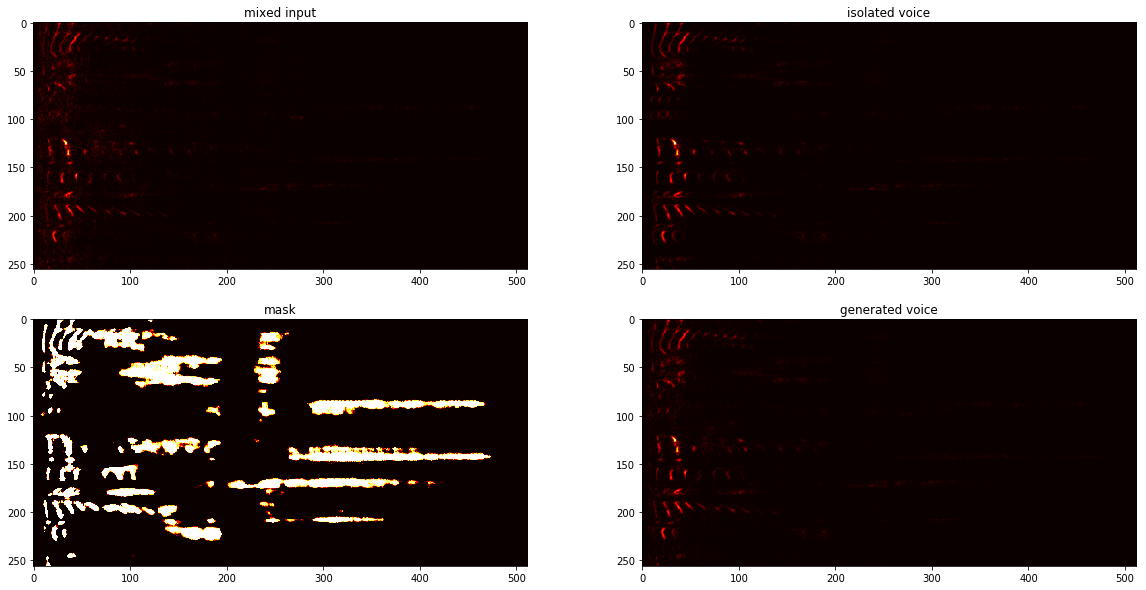

In [31]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix[0,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice[0,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(mix[0,:,:,0] * mask[0,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

In [32]:
mix_wave = []
voice_wave = []
gen_wave = []

for i in range(mix.shape[0]):
    mix_wave.append(af.spectrogramToAudioFile(np.squeeze(mix[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))
    voice_wave.append(af.spectrogramToAudioFile(np.squeeze(voice[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))
    gen_wave.append(af.spectrogramToAudioFile(np.squeeze(mix[i, :, :, :] * mask[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))

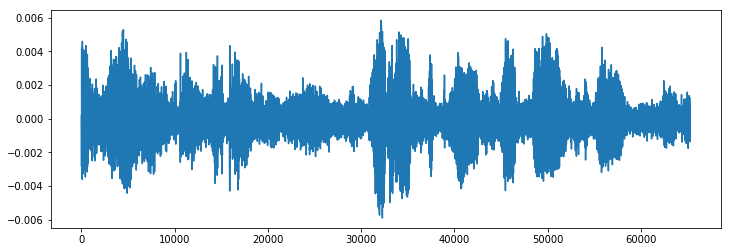

In [37]:
i=0
#  The original mixture
plt.figure(figsize=(12,4))
x = range(len(mix_wave[i]))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i], rate=sample_rate)

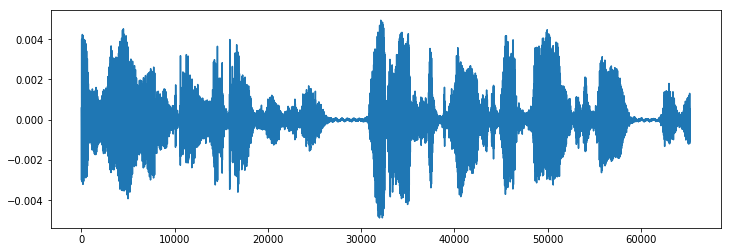

In [34]:
#  The isolated voice
plt.figure(figsize=(12,4))
x = range(len(voice_wave[i]))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i], rate=sample_rate)

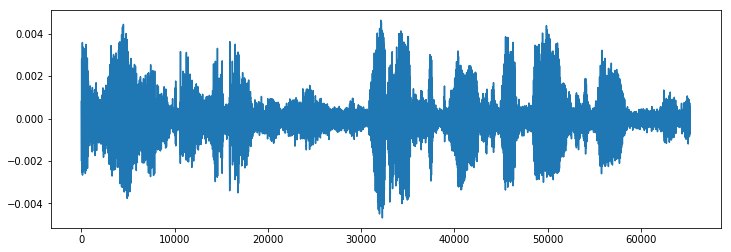

In [35]:
#  The model output
plt.figure(figsize=(12,4))
x = range(len(gen_wave[i]))
plt.plot(x,gen_wave[i])
ipd.Audio(gen_wave[i], rate=sample_rate)

In [ ]:
plt.imshow(mask[4,:,:,0])
plt.show()

In [ ]:
mix[0,:,:,0] * mask[0,:,:,0]

In [ ]:
voice[0,:,:,0]

In [41]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
m_mag, v_mag = sess.run([mixed_mag, voice_mag])

In [44]:
mask = v_mag > 2e-02
masked_mix = m_mag.copy()
masked_mix[mask == 0] = 0

Text(0.5, 1.0, 'Masked Mixture Magnitude Spectrogram')

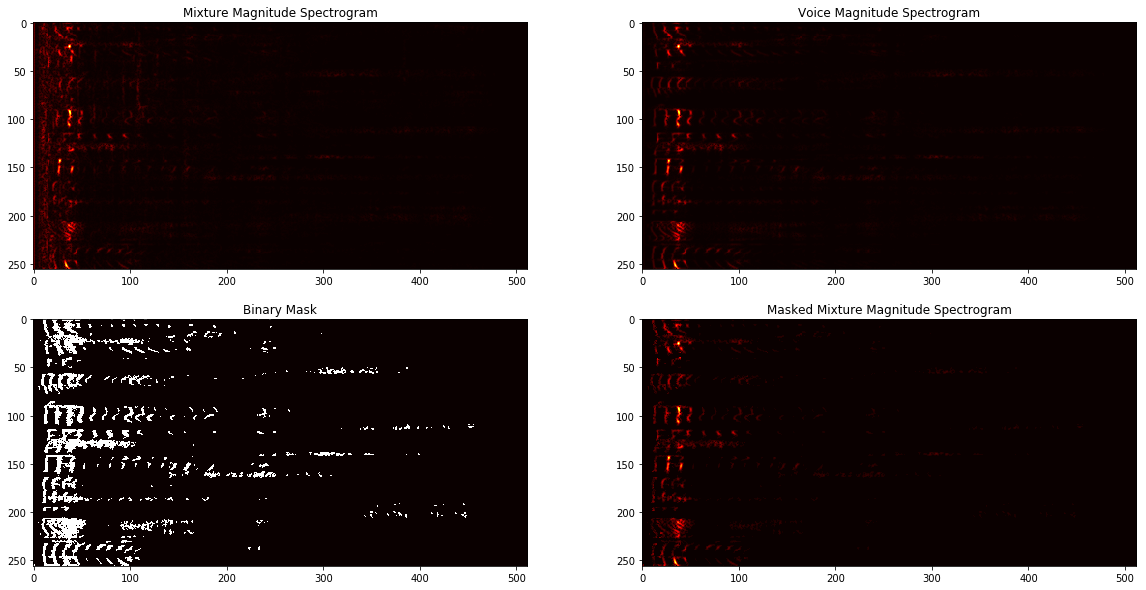

In [45]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(m_mag[0,:,:,0])
ax[0,0].set_title('Mixture Magnitude Spectrogram')
ax[0,1].imshow(v_mag[0,:,:,0])
ax[0,1].set_title('Voice Magnitude Spectrogram')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('Binary Mask')
ax[1,1].imshow(masked_mix[0,:,:,0])
ax[1,1].set_title('Masked Mixture Magnitude Spectrogram')

In [ ]:
class alt_CapsUNetEncoder(object):
    """
    The down-convolutional side of a capsule based U-Net model (based on SegCaps R3 model).
    """
    def __init__(self, input_tensor, is_training, reuse):
        #net = layers.Input(shape=input_tensor)
        net = input_tensor
        with tf.variable_scope('Encoder'):
            with tf.variable_scope('Convolution'):
                # Layer 1: A conventional Conv2D layer
                net = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', name='conv1')(net)

                # Reshape layer to be 1 capsule x [filters] atoms
                _, H, W, C = net.get_shape()
                net = layers.Reshape((H.value, W.value, 1, C.value))(net)
                self.conv1 = net

            with tf.variable_scope('Primary_Caps'):
                # Layer 1: Primary Capsule: Conv cap with routing 1
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=2, num_atoms=16, strides=2, padding='same',
                                                    routings=1, name='primarycaps')(net)
                self.primary_caps = net

            with tf.variable_scope('Conv_caps_2'):
                # Layer 2: Convolutional Capsules
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1, padding='same',
                                                      routings=3, name='conv_cap_2_1')(net)
                self.conv_cap_2_1 = net

                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=2, padding='same',
                                                      routings=3, name='conv_cap_2_2')(net)
                self.conv_cap_2_2 = net

            with tf.variable_scope('Conv_caps_3'):
                # Layer 3: Convolutional Capsules
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                                      routings=3, name='conv_cap_3_1')(net)
                self.conv_cap_3_1 = net

                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=64, strides=2, padding='same',
                                                    routings=3, name='conv_cap_3_2')(net)
                self.conv_cap_3_2 = net

            with tf.variable_scope('Conv_caps_4'):
                # Layer 4: Convolutional Capsules
                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                                      routings=3, name='conv_cap_4_1')(net)

            self.output = net


class alt_CapsUNetDecoder(object):
    """
    The up-convolutional side of a capsule based U-Net model.
    """
    def __init__(self, input_tensor, encoder, is_training, reuse):
        net = input_tensor
        with tf.variable_scope('Decoder'):
            with tf.variable_scope('UpCaps_1'):
                    # Layer 1 Up: Deconvolutional capsules, skip connection, convolutional capsules
                net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=8, num_atoms=32, upsamp_type='deconv',
                                                        scaling=2, padding='same', routings=3, name='deconv_cap_1_1')(net)
                self.upcap_1_1 = net

                net = layers.Concatenate(axis=-2, name='up_1')([net, encoder.conv_cap_3_1])

                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=1,
                                                      padding='same', routings=3, name='deconv_cap_1_2')(net)
                self.upcap_1_2 = net

            with tf.variable_scope('UpCaps_2'):
                # Layer 2 Up: Deconvolutional capsules, skip connection, convolutional capsules
                net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=4, num_atoms=16, upsamp_type='deconv',
                                                        scaling=2, padding='same', routings=3, name='deconv_cap_2_1')(net)
                self.upcap_2_1 = net

                net = layers.Concatenate(axis=-2, name='up_2')([net, encoder.conv_cap_2_1])

                net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1,
                                                      padding='same', routings=3, name='deconv_cap_2_2')(net)
                self.upcap_2_2 = net

            with tf.variable_scope('UpCaps_3'):
                # Layer 3 Up: Deconvolutional capsules, skip connection
                net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=2, num_atoms=16, upsamp_type='deconv',
                                                        scaling=2, padding='same', routings=3, name='deconv_cap_3_1')(net)
                self.upcap_3_1 = net

                net = layers.Concatenate(axis=-2, name='up_3')([net, encoder.conv1])
            with tf.variable_scope('Reconstruction'):
                # Layer 4: Reconstruction - Convolutional Capsule: 1x1, 3x conventional Conv2D layers
                net = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
                                                      routings=3, name='seg_caps')(net)
                
                _, H, W, C, D = net.get_shape()
                
                net = layers.Reshape((H.value, W.value, D.value))(net)

                net = layers.Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                    activation='relu', name='recon_1')(net)

                net = layers.Conv2D(filters=128, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                    activation='relu', name='recon_2')(net)

                net = layers.Conv2D(filters=1, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                    activation='sigmoid', name='out_recon')(net)

            self.output = net